<h1># Open again in assistant editor to compare</h1>

In [41]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import IPython.display
import numpy as np
from cued_sf2_lab.familiarisation import load_mat_img, plot_image
from cued_sf2_lab.jpeg import jpegdec, jpegenc
from scipy import optimize

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
lighthouse, _ = load_mat_img(img='lighthouse.mat', img_info='X')
bridge, _ = load_mat_img(img='bridge.mat', img_info='X')
flamingo, _ = load_mat_img(img='flamingo.mat', img_info='X')

lighthouse = lighthouse - 128.0
bridge = bridge - 128.0
flamingo = flamingo - 128.0

<h1>Raw</h1>

Size = 524288, Err = 0.0


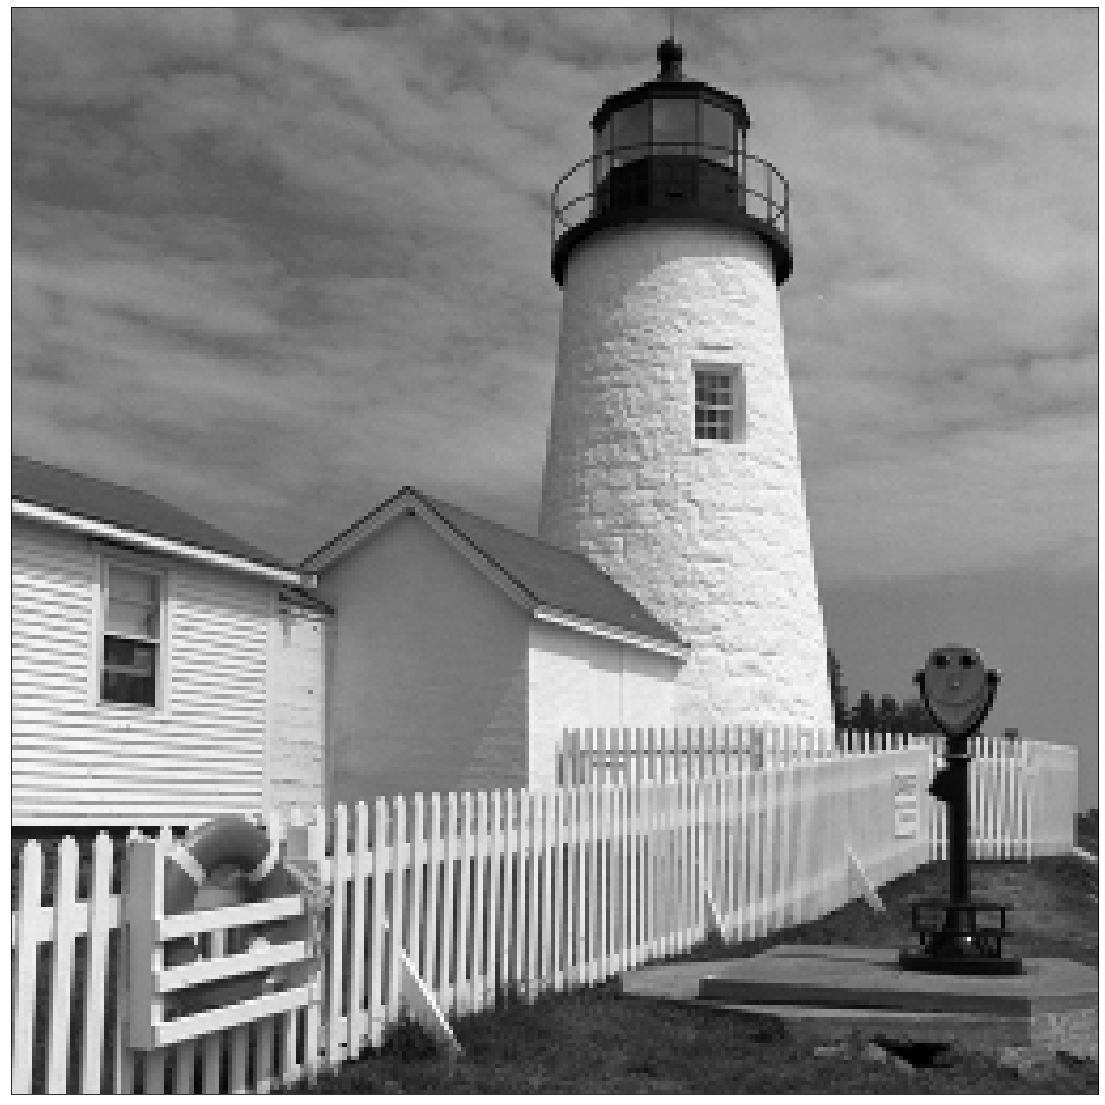

In [336]:
fig, ax = plt.subplots(figsize=(20, 20))

plot_image(lighthouse, ax=ax)
ax.set(yticks=[], xticks=[])

fig.savefig("figs/l_raw.pdf")

print(f'Size = {256*256*8}, Err = {np.std(0):.4}')

In [91]:
print(np.max(lighthouse), np.min(lighthouse))

120.0 -128.0


<h1>JPEG (slow)</h1>

Size = 34805, Err = 9.303


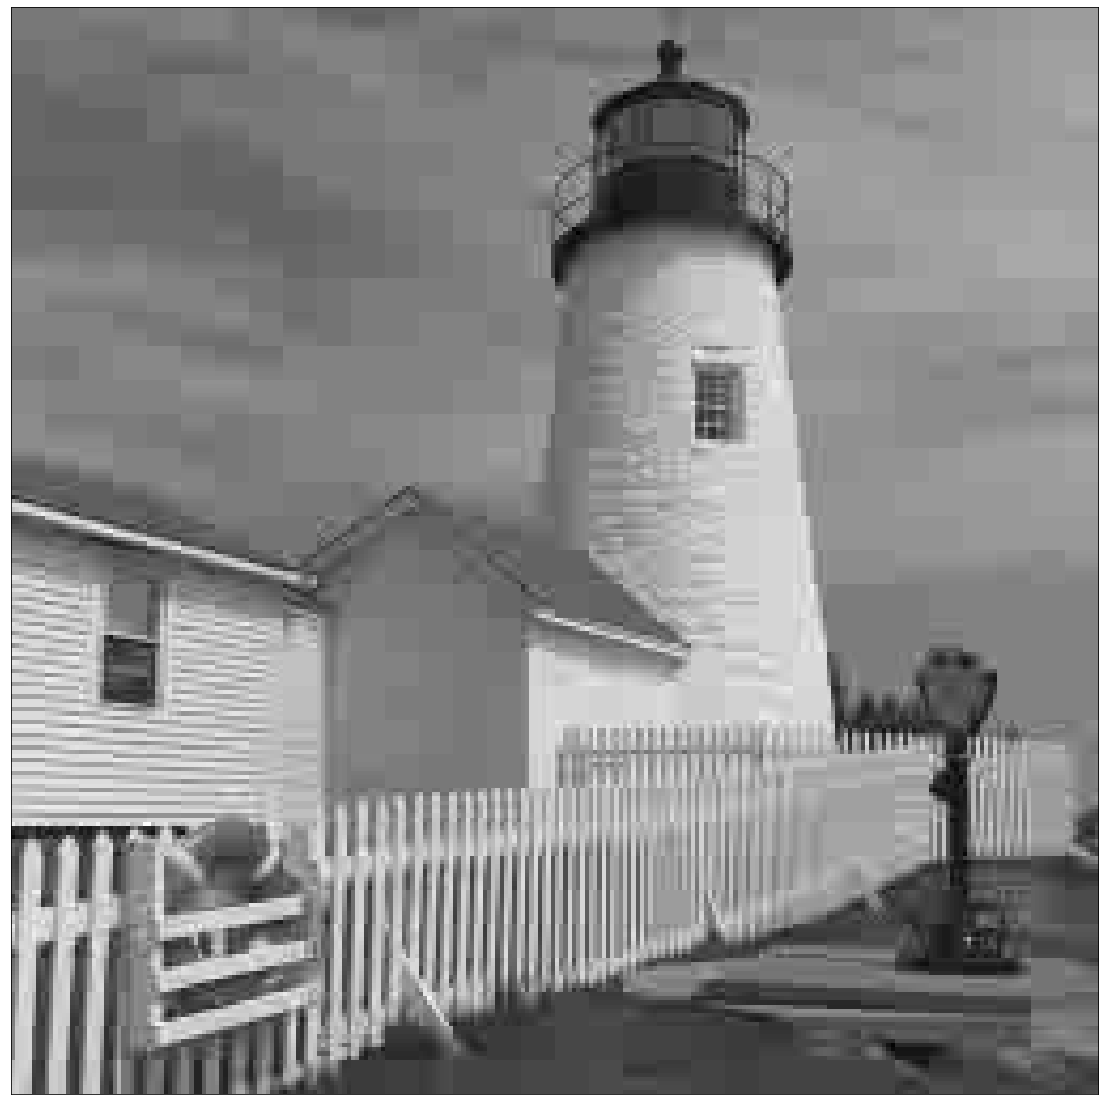

In [337]:
size_lim = 40950

def error(qstep: int) -> int:

    Z, h = jpegenc(lighthouse, qstep, opthuff=True, dcbits=16, log=False)
    size = Z[:, 1].sum()
    return np.sum((size - size_lim)**2)

opt_step = optimize.minimize_scalar(error, method="bounded", bounds=(16, 128)).x
vlc, hufftab = jpegenc(lighthouse, opt_step, opthuff=True, dcbits=10, log=False)

Z = jpegdec(vlc, opt_step, hufftab=hufftab, dcbits=10, log=False)

fig, ax = plt.subplots(figsize=(20, 20))
plot_image(Z, ax=ax)
ax.set(yticks=[], xticks=[])

fig.savefig("figs/l_jpeg_opthuff_dc16bits.pdf")


print(f'Size = {vlc[:, 1].sum()}, Err = {np.std(Z - lighthouse):.4}')

<h1>DWT</h1>

In [4]:

from compression import DWTCompression, LBTCompression

Size = 40900, Err = 8.443


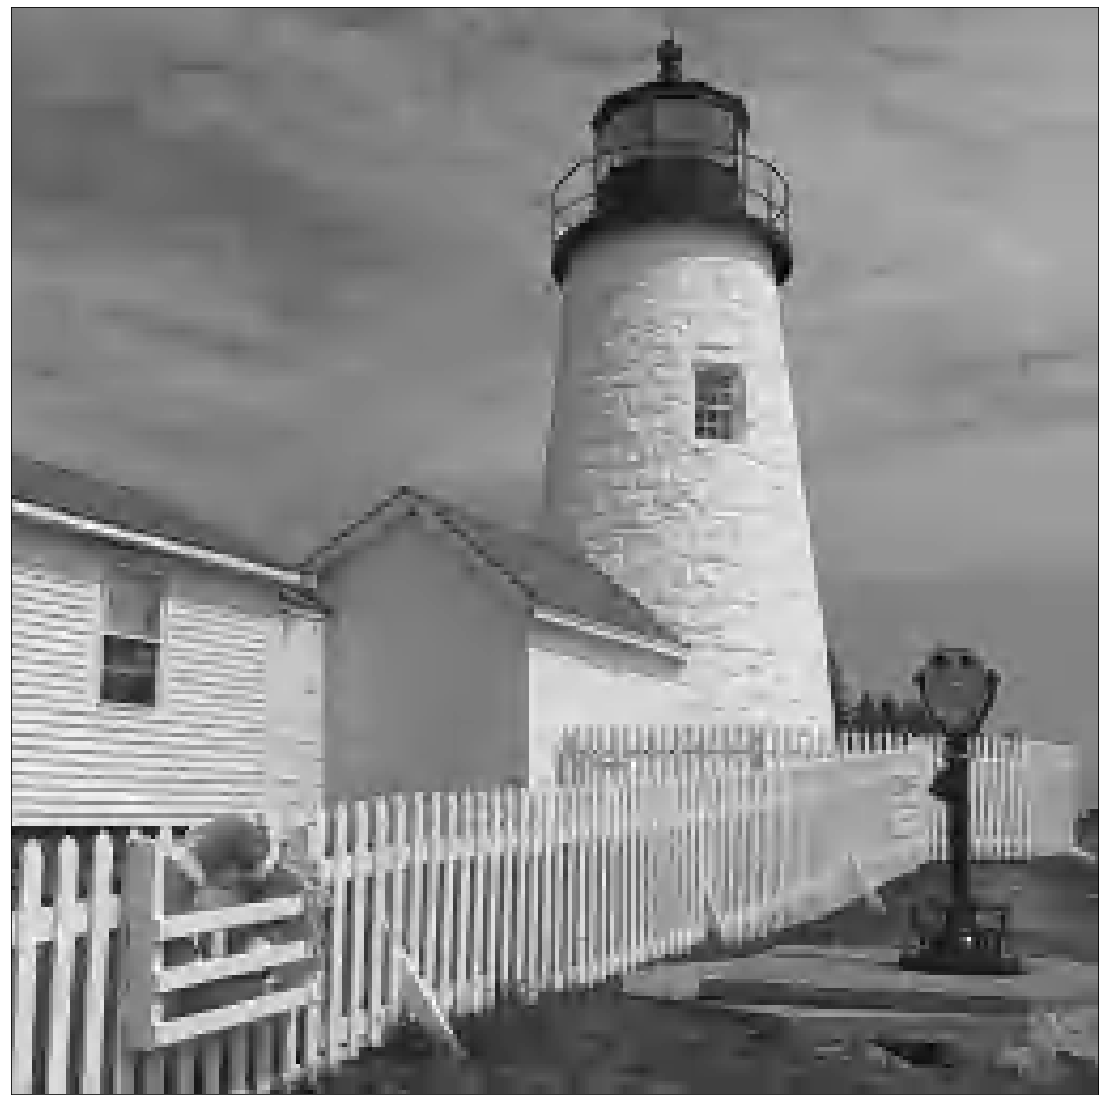

In [338]:
fig, ax = plt.subplots(figsize=(20, 20))

DWT = DWTCompression(5)

Y1 = DWT.compress(lighthouse)

(vlc, hufftab), qs = DWT.opt_encode(Y1, size_lim=40950, root2=False)

Y = DWT.decode(vlc, qstep=qs, hufftab=hufftab, root2=False)

Z = DWT.decompress(Y)

plot_image(Z, ax=ax)
print(f'Size = {vlc[:, 1].sum()}, Err = {np.std(Z - lighthouse):.4}')

ax.set(yticks=[], xticks=[])

fig.savefig("figs/l_dwt_opthuff.pdf")

<h1>DWT with Intermediary sqrt(2) Q Steps</h1>

Err 8.443


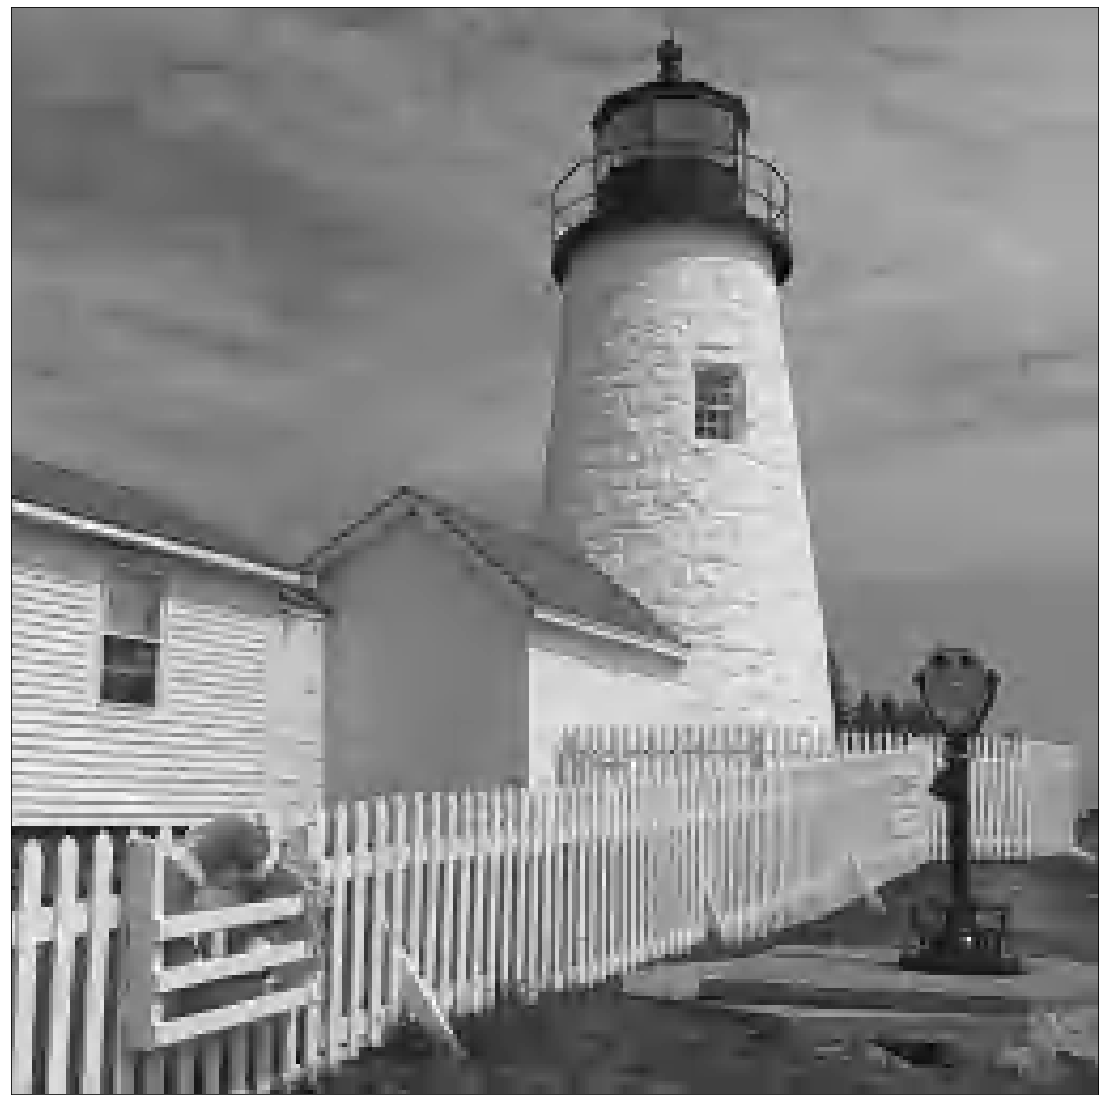

In [342]:
fig, ax = plt.subplots(figsize=(20, 20))

DWT = DWTCompression(5)

Y1 = DWT.compress(lighthouse)

(vlc, hufftab), qs = DWT.opt_encode(Y1, size_lim=40950)

Y = DWT.decode(vlc, qstep=qs, hufftab=hufftab)

Z = DWT.decompress(Y)

plot_image(Z, ax=ax)
print(f'Err {np.std(Z - lighthouse):.4}')

ax.set(yticks=[], xticks=[])

fig.savefig("figs/l_dwt_opthuff_root2.pdf")


<h1>LBT</h1>

Size = 56266, Err = 6.208


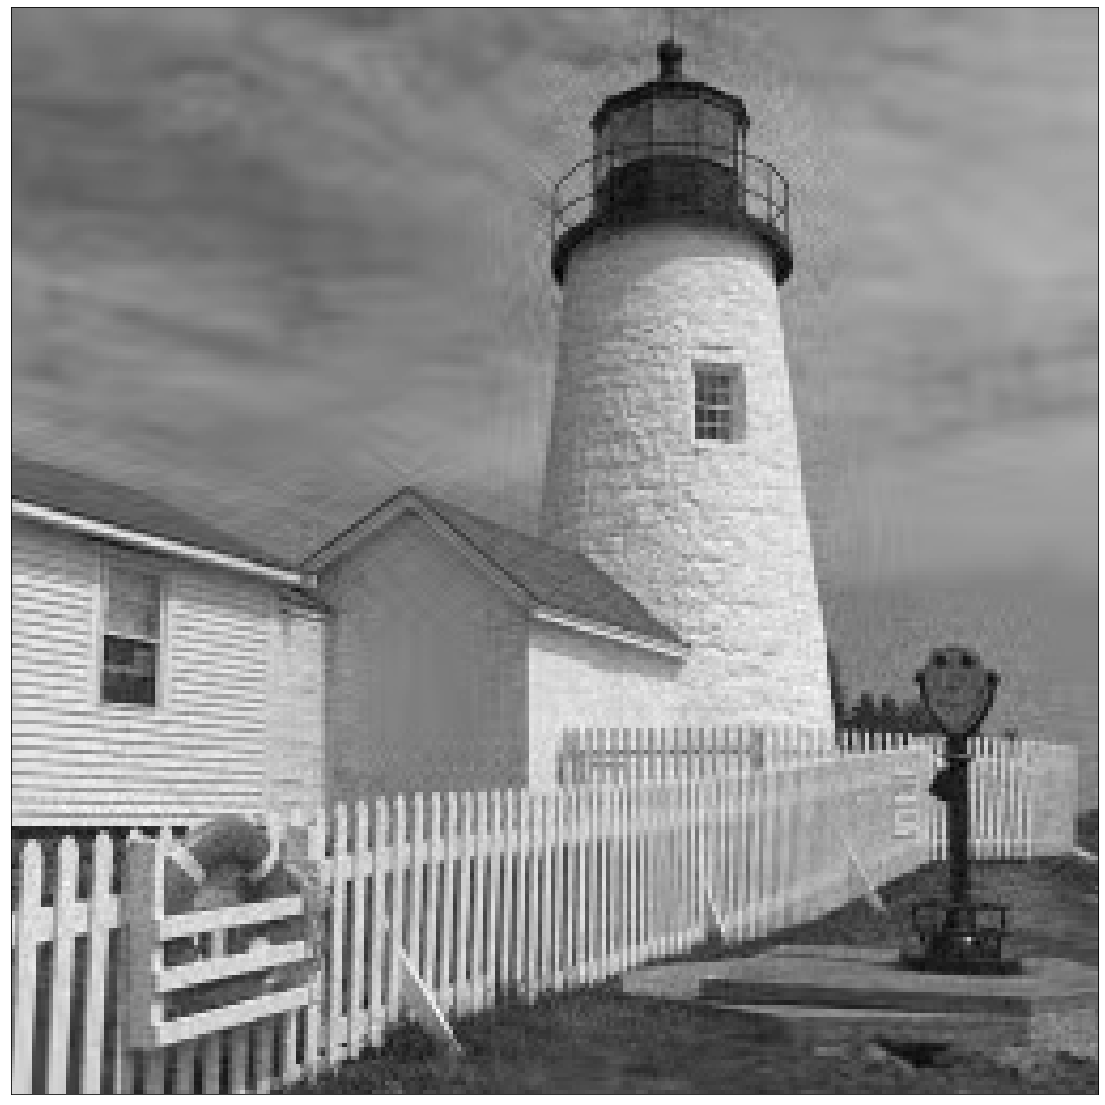

In [308]:
M = 16

scheme = LBTCompression(s=1.3, N=M)
image = lighthouse

fig, ax = plt.subplots(figsize=(20, 20))

Y = scheme.compress(image)
(vlc, hufftab), qs = scheme.opt_encode(Y, size_lim=40950, M=M)
header = (hufftab, qs)

Y = scheme.decode(vlc, qstep=header[1], M=M, hufftab=header[0])
Z1 = scheme.decompress(Y)

plot_image(Z1, ax=ax)
print(f'Size = {vlc[:, 1].sum()}, Err = {np.std(Z1 - image):.4}')

ax.set(yticks=[], xticks=[])

fig.savefig("figs/l_lbt_opthuff.pdf")

<h1>LBT with Quantisation Gradient</h1>

Size = 34408, Err = 49.9


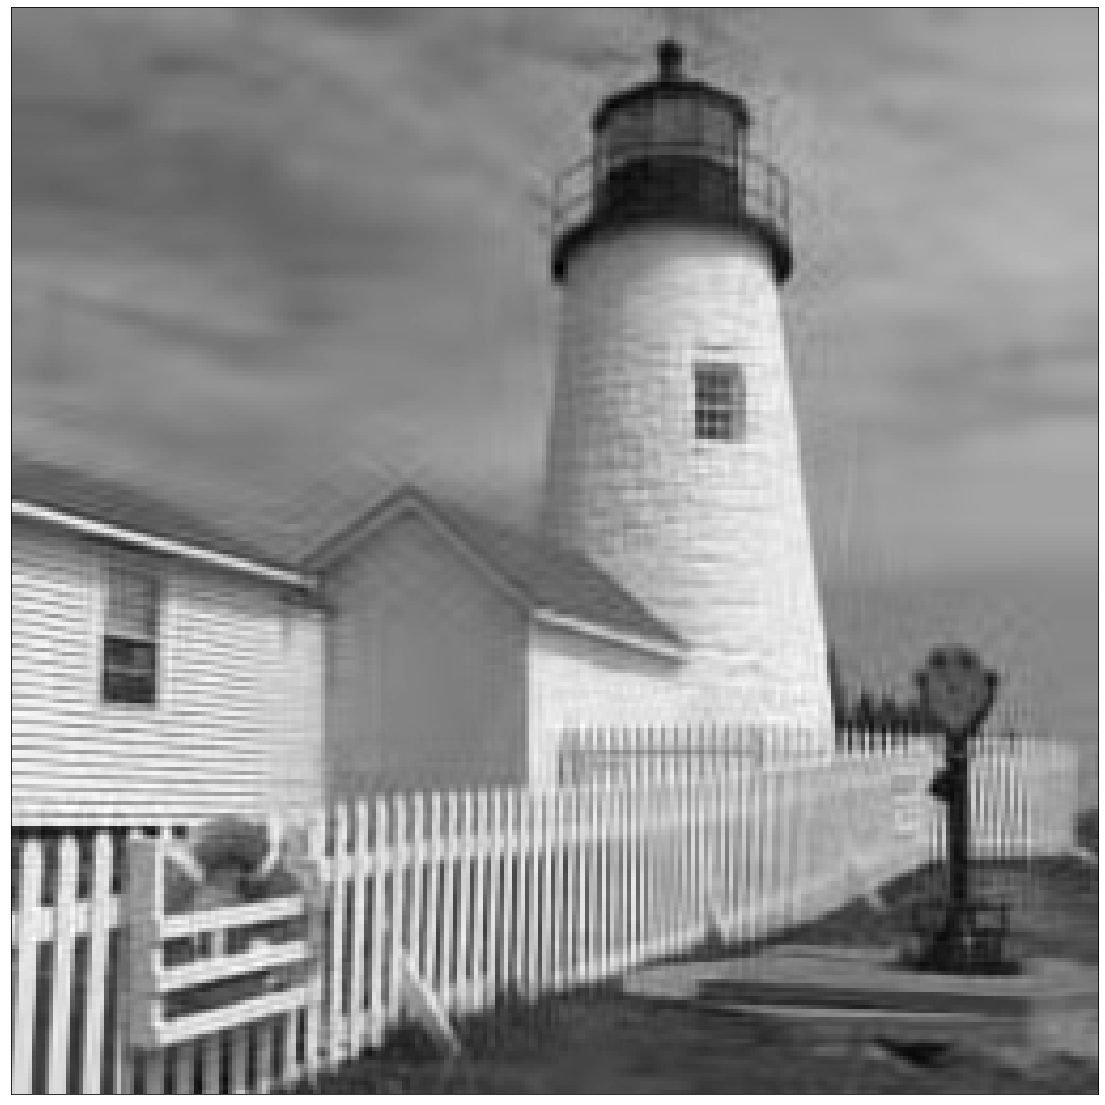

In [335]:
# Quantisation gradient top left to bottom right, apparently just lightly high passes but introduces massive RMS error

M = 16

scheme = LBTCompression(s=1.3, N=M)
image = lighthouse

fig, ax = plt.subplots(figsize=(20, 20))

Y = scheme.compress(image)
(vlc, hufftab), qs = scheme.opt_encode(Y, size_lim=40950, M=M, quant_grad=True)
header = (hufftab, qs)

Y = scheme.decode(vlc, qstep=header[1], M=M, hufftab=header[0], quant_grad=True)
Z1 = scheme.decompress(Y)
plot_image(Z1, ax=ax)
print(f'Size = {vlc[:, 1].sum()}, Err = {np.std(Z1 - image):.4}')

ax.set(yticks=[], xticks=[])

fig.savefig("figs/l_lbt_opthuff_qgrad.pdf")